# Intrinsic growth rate

This is the example from section 4.8 of Saltelli et al, 2008, *Global Sensitivity Analysis: A Primer*.

The intrinsic growth rate
$$Y(\gamma, k, r, \delta) = \gamma k S_0 - r- \delta,$$
where
$$\begin{aligned}
\gamma &\sim \mathrm{U}(0, 1), \\
r &\sim \mathrm{U}(0, 1), \\
\delta &\sim \mathrm{U}(0, 1), \\
S_0 &= 1000,
\end{aligned}$$
and $k$ will vary across 3 different cases:
$$\begin{aligned}
k &\sim \mathrm{Beta}(2, 7), \\
k &\sim \mathrm{Beta}(0.5, 10), \text{or} \\
k &\sim \mathrm{Beta}(0.2, 15).
\end{aligned}$$

In [1]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import stats
from scipy import fft
import statsmodels.api

import sensitivity_analysis


def model(𝛾, k, r, 𝛿, S_0=1000):
    '''The intrinsic growth rate.'''
    return 𝛾 * k * S_0 - r - 𝛿


# Different cases of the a & b values for k ~ Beta(a, b).
k_parameters = ((2, 7), 
                (0.5, 10), 
                (0.2, 15))

parameter_sets = {
    f'Case {i + 1}': dict(𝛾=stats.uniform(0, 1),
                          k=stats.beta(a, b),
                          r=stats.uniform(0, 1),
                          𝛿=stats.uniform(0, 1))
    for (i, (a, b)) in enumerate(k_parameters)}

n_samples = 1280

### Figure 4.2

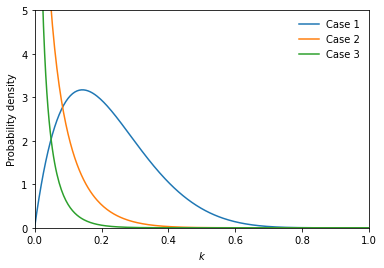

In [2]:
x = numpy.linspace(0, 1, 301)
p = 'k'
for (case, parameters) in parameter_sets.items():
    pyplot.plot(x, parameters[p].pdf(x), label=case)
pyplot.autoscale(tight=True)
pyplot.xlabel(f'${p}$')
pyplot.ylabel('Probability density')
pyplot.ylim(0, 5)
_ = pyplot.legend()

### Figure 4.1

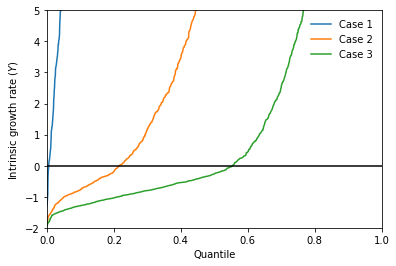

In [3]:
q = numpy.linspace(0, 1, n_samples)
for (case, parameters) in parameter_sets.items():
    X = sensitivity_analysis.sampling.get_unstructured(parameters, n_samples)
    Y = model(**X)
    pyplot.plot(q, numpy.sort(Y), label=case)
pyplot.axhline(0, color='black')
pyplot.xlabel('Quantile')
pyplot.ylabel('Intrinsic growth rate ($Y$)')
pyplot.autoscale(tight=True)
pyplot.ylim(-2, 5)
_ = pyplot.legend()

## Sobol' indexes

### Tables 4.1, 4.2, & 4.3

In [4]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', 'Total-order index ($S_T$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


alpha = 0.1
for (case, parameters) in parameter_sets.items():
    (S, S_PE, S_T, S_T_PE) = sensitivity_analysis.sobol_index.get_indexes(
        model, parameters, n_samples, alpha=alpha)
    print(case)
    display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=alpha)

Case 1


Case 2


Case 3


### Random Balance Designs

A more-efficient method for computing Sobol's first-order index ($S$).

#### Table 4.4

In [5]:
S_RBD = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S_RBD[case] = sensitivity_analysis.sobol_index.get_S_RBD(
        model, parameters, n_samples)

table = S_RBD.copy()
table.loc['Sum'] = table.sum()
display(table.style.apply(bold_sum))

,Case 1,Case 2,Case 3
γ,0.404895,0.139215,0.0570645
k,0.401738,0.595596,0.571669
r,0.00697328,0.0138596,0.0154482
δ,0.00576,0.0148038,0.00887923
Sum,0.819366,0.763475,0.653061


#### Plots of $\mathrm{E}_{X_{\sim i}}(Y | X_i)$

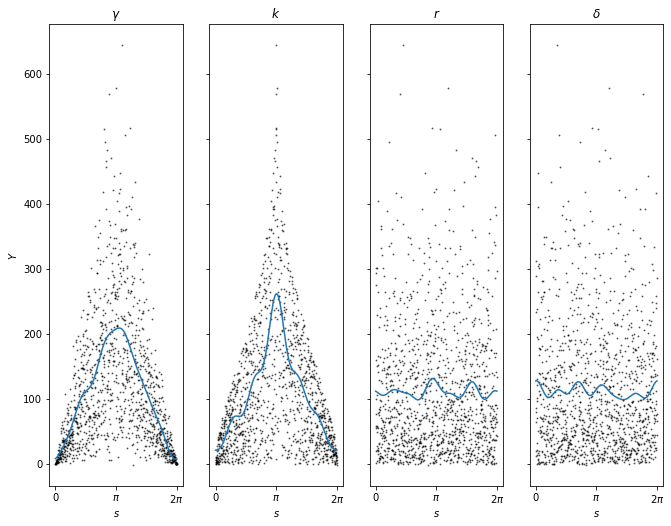

In [6]:
parameters = parameter_sets['Case 1']
n_params = len(parameters)

n_freqs = 6

s_0 = numpy.linspace(0, 2 * numpy.pi, n_samples)
index = parameters.keys()
s = pandas.DataFrame({i: numpy.random.permutation(s_0)
                      for i in index})
q = numpy.arccos(numpy.cos(s)) / numpy.pi
X = pandas.DataFrame({i: parameters[i].ppf(q[i])
                      for i in index})
Y = model(**X)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(s[i], Y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(s[i])
    Y_reordered = Y[order]
    Y_hat = numpy.fft.rfft(Y_reordered)
    Y_hat[n_freqs + 1 :] = 0
    EYXnoti = numpy.fft.irfft(Y_hat, n_samples)
    ax.plot(s_0, EYXnoti)
    ax.set_xlabel(f'$s$')
    ax.set_xticks([0, numpy.pi, 2 * numpy.pi])
    ax.set_xticklabels([0, '$\pi$', '$2 \pi$'])
    ax.set_title(f'${i}$')
axes[0].set_ylabel('$Y$')
pyplot.show()

#### Alternatives to Fourier series for $\mathrm{E}_{X_{\sim i}}(Y|X_i)$

What if we try Fourier cosine series, 5th-order polynomials, or LOWESS instead?

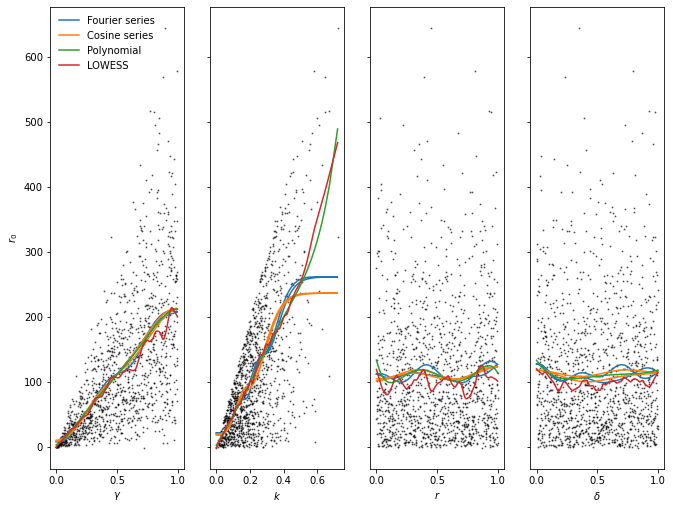

,Fourier,Cosine,Polynomial,LOWESS
γ,0.422555,0.422269,0.421622,0.360987
k,0.442508,0.431475,0.4635,0.492026
r,0.00660639,0.00348613,0.00641495,0.0134643
δ,0.00629202,0.00291807,0.00281048,0.00581336
Sum,0.877961,0.860147,0.894348,0.87229


In [7]:
S = pandas.Series(index=index)
S_cos = pandas.Series(index=index)
S_lowess = pandas.Series(index=index)
S_poly = pandas.Series(index=index)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(X[i], Y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(s[i])
    Y_reordered = Y[order]
    Y_hat = numpy.fft.rfft(Y_reordered)
    # Fourier series.
    spectrum_Y = 2 * numpy.abs(Y_hat / n_samples) ** 2
    spectrum_EYXnoti = spectrum_Y[: n_freqs + 1]
    var_EYXnoti = spectrum_EYXnoti[1:].sum()
    var_Y = spectrum_Y[1:].sum()
    S[i] = var_EYXnoti / var_Y
    Y_hat[n_freqs + 1 : ] = 0
    EYXnoti = numpy.fft.irfft(Y_hat, n_samples)
    ax.plot(X[i].iloc[order], EYXnoti,
            label='Fourier series')
    # Cosine series.
    # Y_hat = fft.dct(Y[order], norm='ortho')
    # Avoid warning.
    Y_hat = fft.dct(numpy.asarray(Y[order]), norm='ortho')
    spectrum_Y = Y_hat ** 2
    spectrum_EYXnoti = spectrum_Y[: n_freqs + 1]
    var_EYXnoti = spectrum_EYXnoti[1:].sum() / n_samples
    var_Y = spectrum_Y[1:].sum() / n_samples
    S_cos[i] = var_EYXnoti / var_Y
    Y_hat[n_freqs + 1 : ] = 0
    EYXnoti = fft.idct(Y_hat, norm='ortho')
    ax.plot(X[i].iloc[order], EYXnoti,
            label='Cosine series')    
    # Polynomial.
    order = numpy.argsort(X[i])
    p = numpy.polyfit(X[i].iloc[order], Y[order],
                      deg=5)
    EYXnoti = numpy.polyval(p, X[i].iloc[order])
    S_poly[i] = numpy.var(EYXnoti, ddof=1) / numpy.var(Y, ddof=1)
    ax.plot(X[i].iloc[order], EYXnoti,
            label='Polynomial')
    # LOWESS.
    EYXnoti = statsmodels.api.nonparametric.lowess(
        Y[order], X[i].iloc[order],
        frac=0.1, it=1,
        is_sorted=True, return_sorted=False)
    S_lowess[i] = numpy.var(EYXnoti, ddof=1) / numpy.var(Y, ddof=1)
    ax.plot(X[i].iloc[order], EYXnoti,
            label='LOWESS')
    ax.set_xlabel(f'${i}$')
axes[0].set_ylabel('$r_0$')
axes[0].legend()
pyplot.show()

table = pandas.DataFrame({'Fourier': S,
                          'Cosine': S_cos,
                          'Polynomial': S_poly,
                          'LOWESS': S_lowess})
table.loc['Sum'] = table.sum()
display(table.style.apply(lambda s: ['font-weight: bold' if v else '' for v in (s.index == 'Sum')]))

##### Problem

Can we figure out how to compute the total-order indexes
$$S_{\mathrm{T}i}
= \frac{\mathrm{E}_{X_{\sim i}}\big(\mathrm{V}_{X_i}(Y|X_{\sim i})\big)}{\mathrm{V}(Y)}
= 1 - \frac{\mathrm{V}_{X_{\sim i}}\big(\mathrm{E}_{X_i}(Y|X_{\sim i})\big)}{\mathrm{V}(Y)}
$$
using the $n$-dimensional FFT or other interpolant?

We should probably first try the second-order indexes
$$S_{ij} = \frac{\mathrm{V}_{X_i, X_j}\big(\mathrm{E}_{X_{\sim i, j}}(Y|X_i, X_j)\big)}{\mathrm{V}(Y)}.$$

### Random Balance Designs using the DCT

A cleaner method for computing Random Balance Designs using the DCT instead of the FFT.

#### Table 4.4 again

In [8]:
S_RBD_DCT = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S_RBD_DCT[case] = sensitivity_analysis.sobol_index.get_S_RBD_DCT(
        model, parameters, n_samples)

table = S_RBD_DCT.copy()
table.loc['Sum'] = table.sum()
display(table.style.apply(bold_sum))

,Case 1,Case 2,Case 3
γ,0.430267,0.11609,0.0462368
k,0.442657,0.598901,0.586502
r,0.0173491,0.0088246,0.00367794
δ,0.00377406,0.00507817,0.00408071
Sum,0.894046,0.728894,0.640498


#### Plots of $\mathrm{E}_{X_{\sim i}}(Y | X_i)$

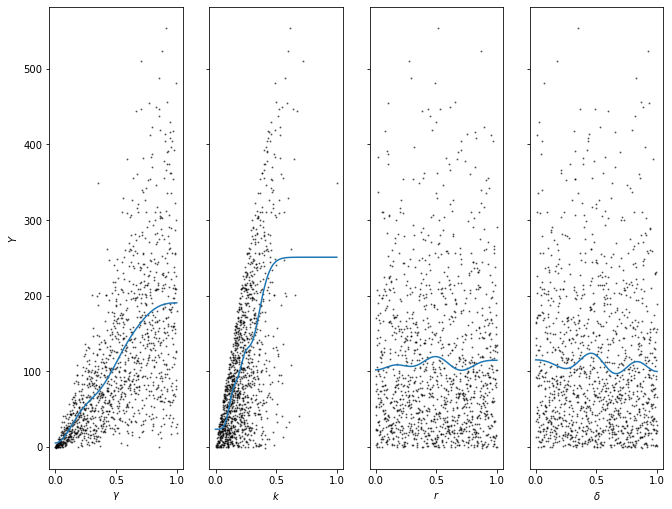

In [9]:
parameters = parameter_sets['Case 1']
n_params = len(parameters)

n_freqs = 6

q_0 = numpy.linspace(0, 1, n_samples)
index = parameters.keys()
q = pandas.DataFrame({i: numpy.random.permutation(q_0)
                      for i in index})
X = pandas.DataFrame({i: parameters[i].ppf(q[i])
                      for i in index})
Y = model(**X)
(fig, axes) = pyplot.subplots(1, len(index), sharey=True, figsize=(11, 8.5))
for (i, ax) in zip(index, axes):
    ax.scatter(X[i], Y,
               s=1, color='black', alpha=0.5)
    order = numpy.argsort(q[i])
    # Y_hat = fft.dct(Y[order], norm='ortho')
    # Avoid warning.
    Y_hat = fft.dct(numpy.asarray(Y[order]), norm='ortho')
    Y_hat[n_freqs + 1 :] = 0
    EYXnoti = fft.idct(Y_hat, norm='ortho')
    ax.plot(X[i].iloc[order], EYXnoti)
    ax.set_xlabel(f'${i}$')
axes[0].set_ylabel('$Y$')
pyplot.show()

## Derivatives

In [20]:
S2_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    S = sensitivity_analysis.local.get_sensitivity_sigma_normalized(
        model, parameters, n_samples)
    S2_sigma[case] = S ** 2

table = S2_sigma.copy()
table.loc['Sum'] = table.sum()
display(table.style.apply(bold_sum))

,Case 1,Case 2,Case 3
γ,0.437876,0.114726,0.0495992
k,0.460047,0.603039,0.685406
r,8.86753e-06,5.05157e-05,0.000286375
δ,8.86655e-06,5.05154e-05,0.000286361
Sum,0.897941,0.717866,0.735578


## Linear regression

In [23]:
beta2_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    beta = sensitivity_analysis.linear_regression.get_coefficients_standardized(
        model, parameters, n_samples)
    beta2_sigma[case] = beta ** 2

table = beta2_sigma.copy()
table.loc['Sum'] = table.sum()
display(table.style.apply(bold_sum))

,Case 1,Case 2,Case 3
γ,0.417274,0.135063,0.0534618
k,0.428692,0.622931,0.689061
r,0.000874953,0.00160264,0.000625405
δ,0.000640389,0.000279716,0.000397503
Sum,0.847481,0.759876,0.743546


## Derivative-based global sensitivity measure

From Lamboni et al, 2013, with the measure here also weighted by the variances.

In [59]:
DGSM_sigma = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    DGSM_sigma[case] = sensitivity_analysis.dgsm.get_DGSM_sigma_normalized(
        model, parameters, n_samples)

table = DGSM_sigma.copy()
table.loc['Sum'] = table.sum()
display(table.style.apply(bold_sum))

,Case 1,Case 2,Case 3
γ,0.549259,0.321261,0.282513
k,0.568965,0.814328,0.925795
r,8.24469e-06,5.1968e-05,0.000296853
δ,8.24394e-06,5.19705e-05,0.000296854
Sum,1.11824,1.13569,1.2089


## Partial rank correlation coefficients

In [63]:
PRCC = pandas.DataFrame(columns=parameter_sets.keys())
for (case, parameters) in parameter_sets.items():
    PRCC[case] = sensitivity_analysis.prcc.get(model, parameters, n_samples)

display(PRCC)

,Case 1,Case 2,Case 3
γ,0.918563,0.821185,0.488578
k,0.899211,0.952900,0.905439
r,-0.031899,-0.173767,-0.476884
δ,-0.019309,-0.167017,-0.468012
